### Maxwell A. Fine 14880725
### Assingment 2: Stastical Methods in Astrophysics

In [93]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
import scipy.integrate as spint
import scipy.interpolate as spinterp
from scipy.integrate import simps
from uncertainties import ufloat

# Set a seed for reproducibility
random_seed = 50

# Gaia correction term
gaia_corr = 0.029

### Initial Setup
First, load in the stars data as shown in Assignment 1, and create a dataframe containing only stars with Prob > 0.8, which you will use for the remainder of this assignment.

In [67]:
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()
stars = stars[stars['Prob']>0.8]
clcounts = stars.groupby(['Name']).size().reset_index(name='count') 

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


ColDefs(
    name = 'Name'; format = 'A20'; start = 1
    name = 'ID'; format = 'I4'; disp = 'I4'; start = 22
    name = 'GaiaDR3'; format = 'I19'; disp = 'I19'; start = 27
    name = 'inrt'; format = 'I1'; disp = 'I1'; start = 47
    name = 'Prob'; format = 'F10.8'; disp = 'F10.8'; start = 49
    name = 'RAdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 60
    name = 'e_RAdeg'; format = 'F10.8'; unit = 'arcsec'; disp = 'F10.8'; start = 73
    name = 'DEdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 84
    name = 'e_DEdeg'; format = 'F10.8'; unit = 'arcsec'; disp = 'F10.8'; start = 97
    name = 'GLON'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 108
    name = 'GLAT'; format = 'E11.4'; unit = 'deg'; disp = 'E11.4'; start = 121
    name = 'pmRA'; format = 'E11.4'; unit = 'mas/yr'; disp = 'E11.4'; start = 133
    name = 'e_pmRA'; format = 'F10.8'; unit = 'mas/yr'; disp = 'F10.8'; start = 145
    name = 'pmDE'; format = 'E11.4'; unit = 'mas/yr'; d

# Task 1:
Use your stars dataframe to calculate the following 6 sample quantities per cluster: 
- the number of
stars in the cluster �∗; 
- the mean parallax, �$, of the stars in the cluster;
- the standard deviation �& of
the parallax of the stars in the cluster;
- the ‘size’ of the cluster �pos calculated using the standard
deviation in RA and Dec position of the stars1
;
- the mean proper motion of the cluster stars �̅;
- the standard deviation of the proper motion of the cluster stars �- (which can be calculated by adding in quadrature the RA and dec proper motion standard deviations, i.e. the same as for �pos). 

To help you do this in Pandas, you can adapt the code you used for Assignment 1:
clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='n_star')
clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()
where the .std method calculates the sample standard deviations for all numerical quantities in the
stars data frame grouped according to cluster name, and a similar method exists for the sample
mean. Those can then be used to add the required columns to the dataframe with �∗.


Now, select only the clusters which satisfy �∗ > 200, �pos < 1∘
and for these clusters plot the 5
astrometric quantities only (i.e. excluding �∗) in a scatter-matrix plot, to compare each pair of
quantities and show their histograms. Comment on whether there are any clear correlations revealed
by the scatter plots.


### Idea:
* We can use the pandas 'groupby' function to grab all the stars from a cluster and perform our operation
* Make a new pd to hold our resulting data
* Modify last weeks plotting code (write a function this time!) for our corner plot
    - function should take in dataframe, labels for plots, and dataframe paramters (to index!)
    - plot np.log10(data) for convience 

* Name of 6 parameters 
    - 'count' : # Number of stars in the cluster
    - 'Plx' : # Parallax of the star
    - 'RAdeg' : #  RA in deg
    - 'pmra' : # proper motion of the star
    - Other parameters are calculated by US
        * ' hi all, for the mean proper motion the wording in the assignment is confusing as I mean the net motion of the cluster, e.g. as if you want the motion of the cluster centre of mass. To get this you should calculate the absolute value of the PM by adding in quadrature the mean PM in RA and Dec directions. If you calculate the absolute value of PM for the stars individually and then take the mean of that, you will also be including the motions of stars other than in the overall direction of motion in the cluster, e.g. due to random motions or rotation. This will introduce a correlation between the PM and the standard deviation in PM which we don't want."
        * Told to calculate mean RA and Dec for proper motion and then add in quad
        * Same for other values
    

### Assumptions
- N/A for this problem 

In [68]:
# Cell to calculate cluster stastics 
# Group by 'Name' and calculate the required quantities
cluster_stats = stars.groupby('Name').agg(
    num_stars=('Name', 'count'),  # Number of stars 
    mean_parallax=('Plx', 'mean'),  # Mean parallax
    std_parallax=('Plx', 'std'),  # STD parallax
    mean_proper_motion=('pmRA', 'mean'),  # Mean proper motion
)

# Mean Proper motion
# Quadrature sum of RA and dec to calculate proper motion
mean_pmRA = stars.groupby('Name')['pmRA'].agg('mean')
mean_pmDEC = stars.groupby('Name')['pmDE'].agg('mean') # Ugh why is the data using 'DE' not 'DEC'??
mean_proper_motion = (mean_pmRA**2 + mean_pmDEC**2)**0.5
cluster_stats['mean_proper_motion'] = mean_proper_motion

# Size
# Quadrature sum of RA and dec to calculate 'Size'
std_radeg = stars.groupby('Name')['RAdeg'].agg('std')
std_decdeg = stars.groupby('Name')['DEdeg'].agg('std') # Ugh why is the data using 'DE' not 'DEC'??
size = (std_radeg**2 + std_decdeg**2)**0.5
cluster_stats['cluster_size'] = size

# STD proper motion
# Quadrature sum of RA and dec proper motion standard deviations
# I do not feel this is correct, but not sure how to go about this correct, should I take the mean of the e_pmRA and e_pmDec and add in quad?
# I only joined the slac / learned of the 
std_pm_ra = stars.groupby('Name')['pmRA'].agg('std')
std_pm_dec = stars.groupby('Name')['pmDE'].agg('std')
std_proper_motion = (std_pm_ra**2 + std_pm_dec**2)**0.5

# Add the calculated standard deviation of proper motion to the cluster_stats DataFrame
cluster_stats['std_proper_motion'] = std_proper_motion

# Filter only keeping num_stars > 200 & cluster_size < 1 degree
filtered_cluster_stats = cluster_stats[(cluster_stats['num_stars'] > 200) & (cluster_stats['cluster_size'] < 1)].reset_index()
filtered_cluster_stats


,Name,num_stars,mean_parallax,std_parallax,mean_proper_motion,cluster_size,std_proper_motion
0,BH_131,227,0.125637,0.046214,6.536827,0.221680,0.154404
1,BH_140,338,0.190195,0.043486,14.897046,0.127424,0.129645
2,BH_66,355,0.123089,0.044962,5.470541,0.180838,0.229493
3,Berkeley_36,217,0.217359,0.065872,1.967901,0.063243,0.099389
4,Berkeley_39,211,0.226982,0.038289,2.371439,0.045639,0.068647
...,...,...,...,...,...,...,...
193,UBC_461,231,0.298768,0.031775,4.096675,0.419239,0.109858
194,UBC_517,256,0.405671,0.022682,5.685520,0.716871,0.127498
195,UBC_600,390,0.171171,0.039550,1.191558,0.721515,0.134289
196,UFMG_2,212,0.377292,0.026794,5.382440,0.073233,0.102454


In [69]:
# define corner plot function
# color choice inspired by John
def corner_plot(labels, plotting_df, parameters):
    '''
    Generate a corner plot to visualize relationships between variables.

    Parameters:
    - labels (list): List of labels for each dimension/variable to be plotted.
    - plotting_df (DataFrame): Pandas DataFrame containing the data to be plotted.
    - parameters (list): List of parameter names corresponding to the columns in `plotting_df` to be plotted.

    Returns:
    None

    This function generates a corner plot with subplots showing histograms along the diagonal
    and scatter plots for the relationships between variables in the off-diagonal subplots.
    The plots are based on the specified labels and parameters.

    Note:
    - The function assumes that `plotting_df` is a pandas DataFrame.
    - It uses logarithmic scales for the axes in the scatter plots.
    - The diagonal plots show histograms of the corresponding variables.
    - The off-diagonal plots show scatter plots of the relationships between variables.
    '''
    ndims = len(labels)
    # Nested for loop for plotting
    fig, axes = plt.subplots(ndims, ndims, figsize=(12, 12))
    fig.subplots_adjust(wspace=0.5, hspace=0.4)
    color = '#5F0FFF'

    for i in range(ndims):  # y dimension of the grid
        for j in range(ndims):  # x dimension of the grid
            axes[i, j].tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

            if i == j:
                axes[i, j].hist(np.log10(plotting_df[parameters[i]].values), bins=20, color=color, alpha=0.7)
            elif i > j:
                axes[i, j].scatter(np.log10(plotting_df[parameters[j]].values), np.log10(plotting_df[parameters[i]].values), color=color, alpha=0.3, linewidths=0.5)

            else:
                axes[i, j].axis('off')

            if j == 0:
                if i == j:
                    axes[i, j].set_ylabel('Counts', fontsize=12)
                else:
                    axes[i, j].set_ylabel(labels[i], fontsize=12)

            if i == ndims - 1:
                axes[i, j].set_xlabel(labels[j], fontsize=12)

    plt.suptitle('Filtered Cluster Statstics\n N = ' + str(len(plotting_df[parameters[i]].values)), size=20, y=0.9)
    plt.show()

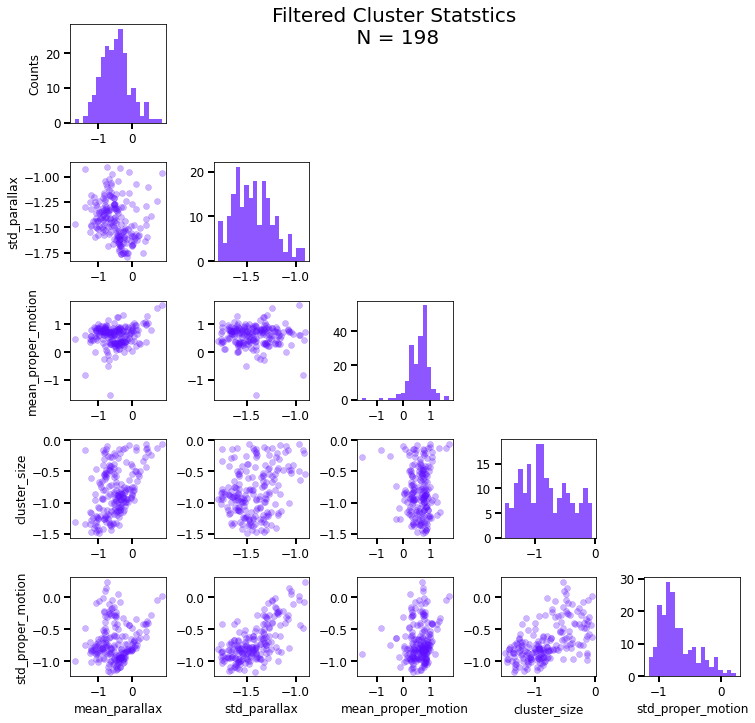

,Name,num_stars,mean_parallax,std_parallax,mean_proper_motion,cluster_size,std_proper_motion
0,BH_131,227,0.125637,0.046214,6.536827,0.221680,0.154404
1,BH_140,338,0.190195,0.043486,14.897046,0.127424,0.129645
2,BH_66,355,0.123089,0.044962,5.470541,0.180838,0.229493
3,Berkeley_36,217,0.217359,0.065872,1.967901,0.063243,0.099389
4,Berkeley_39,211,0.226982,0.038289,2.371439,0.045639,0.068647
...,...,...,...,...,...,...,...
193,UBC_461,231,0.298768,0.031775,4.096675,0.419239,0.109858
194,UBC_517,256,0.405671,0.022682,5.685520,0.716871,0.127498
195,UBC_600,390,0.171171,0.039550,1.191558,0.721515,0.134289
196,UFMG_2,212,0.377292,0.026794,5.382440,0.073233,0.102454


In [70]:
plotting_df = filtered_cluster_stats
labels = ['mean_parallax', 'std_parallax', 'mean_proper_motion', 'cluster_size', 'std_proper_motion']
parameters = labels

corner_plot(labels, plotting_df, parameters)
filtered_cluster_stats


### 1 Comments:

* All parameters appear lognormaly distrubuted aside from cluster size which vaguely looks like uniform
* I see a correlation between std_parallax and std proper motion, perhaps indicative I calculated std_proper_motion wrong
* I see a correlation betwen cluster_size, and parallax, mean proper motion, std proper motion.  I think this is logical, and expected as paralax is a measure (etc) of distance and a further away cluster will have a smaller angular size. Of c
* I do not see visually a correlation between mean proper motion and 
* mean parallax and std propermotion appears to have a linear trend along with more uncorrelated data. Perhaps This represents a limit in the sensitivity of measuring std proper motion for a set mean parallax? Or Indicative I calculated std_proper_motion wrong
* std proper motion and std parllax appear to be correlated


### Conclusion:
I see trends, which could be explained by assuming several of the parameters, and their standard deviations of star clusters are related, and star clusters have inherently different sizes, relative velocities.
proposed related quanties:
* mean parallax
* size
* proper motion


# Task 2 Correlation tests:

### A. 
Now search for correlations by calculating the Pearson and Spearman correlation coefficients
and p-values for each of the combinations shown in the scatter-matrix plots. Comment on
whether the tests are appropriate given the observed distributions of the measured
quantities.
### B. 
You can improve the situation by performing the tests on log-transformed data (i.e. on the
logarithm of the quantities instead of the original values). Why should this make the tests
more reliable? Finally, comment on your results and their implications.



### Idea:
* write a function to calculate pearson and spearman correlations, have a option to do log vs not log


### Assumptions:
* some parameters are related and I expect to see this in the results of the Correlation Tests

* I assume the data is IID. Measurements of stars are Independent of other stars, and as are the clusters. I think they are Identically Distributed because they come from some probability distrubution of star clusters in the MW.

* I assume CTL applies, we have ~180 star clusters so this seems resonable based on the corner plots in 1 however, it is less then n=500 which is the reconmended cutoff from lecture 




In [71]:
# my function breaks for nan and -inf values so we had to update it

def pearson_and_spearman_corr(dataframe, parameters, log=False):
    '''
    Calculate Pearson and Spearman correlation coefficients and p-values for pairs of parameters in a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame containing the data.
    - parameters (list): List of parameter labels for which correlations will be calculated.
    - log (bool, optional): If True, the correlation is calculated on the logarithm of the data. Default is False.

    Returns:
    pd.DataFrame: A DataFrame containing the results with columns:
    - 'Comparison': String indicating the pair of parameters being compared.
    - 'Pearson Coefficient': Pearson correlation coefficient for the pair.
    - 'Pearson P-Value': P-value corresponding to the Pearson correlation.
    - 'Spearman Coefficient': Spearman correlation coefficient for the pair.
    - 'Spearman P-Value': P-value corresponding to the Spearman correlation.
    '''

    # Create an empty DataFrame to store the results
    correlation_results_df = pd.DataFrame(columns=['Comparison', 'Pearson Coefficient',
                                               'Pearson P-Value', 'Spearman Coefficient', 'Spearman P-Value'])

    # Calculate correlation coefficients and p-values
    for label1, label2 in combinations(parameters, 2):

        # Handle NaN, Inf, and -Inf values when taking the log
        # Big fucking hassle 
        if log:
            valid_mask = ~np.isnan(dataframe[label1]) & ~np.isnan(dataframe[label2]) & \
                         ~np.isinf(dataframe[label1]) & ~np.isinf(dataframe[label2])

            if np.any(valid_mask):
                # Use masked array for log transformation
                log_data1 = np.log10(np.ma.masked_invalid(dataframe[label1]))
                log_data2 = np.log10(np.ma.masked_invalid(dataframe[label2]))

                # Calculate Pearson correlation coefficient and p-value
                pearson_corr, pearson_p_value = pearsonr(log_data1[valid_mask], log_data2[valid_mask])

                # Calculate Spearman correlation coefficient and p-value
                spearman_corr, spearman_p_value = spearmanr(log_data1[valid_mask], log_data2[valid_mask])
            else:
                # If all values are NaN, Inf, or -Inf, set correlation values and p-values to NaN
                pearson_corr, pearson_p_value, spearman_corr, spearman_p_value = np.nan, np.nan, np.nan, np.nan
        else:
            # Calculate Pearson correlation coefficient and p-value
            pearson_corr, pearson_p_value = pearsonr(dataframe[label1], dataframe[label2])

            # Calculate Spearman correlation coefficient and p-value
            spearman_corr, spearman_p_value = spearmanr(dataframe[label1], dataframe[label2])

        # Place results in pd, this is similar to a dict
        comparison_key = f'{label1} vs {label2}'
        correlation_results_df = pd.concat([
            correlation_results_df,
            pd.DataFrame({
                'Comparison': [comparison_key],
                'Pearson Coefficient': [pearson_corr],
                'Pearson P-Value': [pearson_p_value],
                'Spearman Coefficient': [spearman_corr],
                'Spearman P-Value': [spearman_p_value]
            })
        ], ignore_index=True)

    return correlation_results_df


In [72]:
# 2A
parameters = ['mean_parallax', 'std_parallax', 'mean_proper_motion', 'cluster_size', 'std_proper_motion']
correlations = pearson_and_spearman_corr(dataframe=filtered_cluster_stats, parameters=parameters, log=False)
log_correlations = pearson_and_spearman_corr(dataframe=filtered_cluster_stats, parameters=parameters, log=True)
correlations

/tmp/ipykernel_22062/1600713121.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([
/tmp/ipykernel_22062/1600713121.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([


,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_parallax vs std_parallax,0.047611,5.053547e-01,-0.376186,4.712017e-08
1,mean_parallax vs mean_proper_motion,0.668548,5.222066e-27,0.051292,4.729721e-01
2,mean_parallax vs cluster_size,0.476555,1.275929e-12,0.373636,5.897056e-08
3,mean_parallax vs std_proper_motion,0.228468,1.206247e-03,0.025229,7.242273e-01
4,std_parallax vs mean_proper_motion,0.129134,6.980531e-02,-0.013398,8.513929e-01
5,std_parallax vs cluster_size,0.341305,8.621712e-07,0.208774,3.160198e-03
6,std_parallax vs std_proper_motion,0.713024,4.760937e-32,0.604036,4.484188e-21
7,mean_proper_motion vs cluster_size,0.236015,8.156744e-04,-0.005288,9.410603e-01
8,mean_proper_motion vs std_proper_motion,0.264974,1.615733e-04,0.153248,3.112366e-02
9,cluster_size vs std_proper_motion,0.403202,3.872148e-09,0.554065,2.508930e-17


In [73]:
# 2B
log_correlations

,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_parallax vs std_parallax,-0.252036,3.409650e-04,-0.376186,4.712017e-08
1,mean_parallax vs mean_proper_motion,0.196391,5.553836e-03,0.051292,4.729721e-01
2,mean_parallax vs cluster_size,0.428522,3.012242e-10,0.373636,5.897056e-08
3,mean_parallax vs std_proper_motion,0.111445,1.180250e-01,0.025229,7.242273e-01
4,std_parallax vs mean_proper_motion,-0.002964,9.669425e-01,-0.013398,8.513929e-01
5,std_parallax vs cluster_size,0.264515,1.660300e-04,0.208774,3.160198e-03
6,std_parallax vs std_proper_motion,0.673524,1.576212e-27,0.604036,4.484188e-21
7,mean_proper_motion vs cluster_size,-0.027338,7.022286e-01,-0.005288,9.410603e-01
8,mean_proper_motion vs std_proper_motion,0.169528,1.695536e-02,0.153248,3.112366e-02
9,cluster_size vs std_proper_motion,0.557149,1.535025e-17,0.554065,2.508930e-17


### 2 Comments:

Cut off p-value of 1e-7, (~5 sigma), we observe the following correlations

For linear correlations:
According to Pearson the following are correlated:
* std parallax vs cluster size
* cluster size vs std proper motion
* std parallax vs std proper motion
* mean parallax vs cluster size 
* mean_parallax vs mean proper motion	

According to Spearman the following are correlated:
* mean_parallax vs std_parallax
* std parallax vs cluster size
* cluster size vs std proper motion
* std parallax vs std proper motion
* mean parallax vs cluster size 

For Log linear correlations:
According to Pearson the following are correlated:
* cluster size vs std proper motion
* std parallax vs std proper motion
* mean parallax vs cluster size 

According to Spearman the following are correlated:
* mean parallax vs mean proper motion
* cluster size vs std proper motion
* std parallax vs std proper motion
* mean parallax vs cluster size 


#### Conclusion 
We reject the null hypothesis! As we hypothized based on the corner plot in 1, the data is strongly correlated for some paramters. 
* It appears that the Spearman test is more sensitive to the correlations, indicative of possilbe outliyers and that it is a monotomic incraesing correlation vs linear
* Some correlations are stronger in linear space vs log space and vice versa. This indicates how the parameters are related. IE mean parallax and cluster size have a higher correlation in linear space. This makes sense as physicaly both depend linearly on distance. 

* A few linear correlations are caused by outlyers like mean_parallax vs mean_proper_motion 






# 3 Intro to Bayesian thinking:

Now randomly select a cluster from the sample used in Task 2. Using the parallaxes of the individual
stars in the cluster, use Bayes’ theorem to calculate the posterior pdf for the distance � (in kpc) to the
cluster, using the formula � = 1/� where � is the parallax in milliarcsec (mas). Gaia has a known
‘zero-point’ offset - a systematic error – in the parallax, so before you do your calculation you
should first add a correction of 0.029 mas to the parallax measurements. You should calculate the
posterior pdf for two different prior pdfs:

a. a uniform prior distrubution 

b. A more realistic pdf corresponding to constant volume density modified by an exponential
decrease with distance: p(d) ~ d^2 exp(-d/l), where L = 1kpc is a charastric length scale

You may assume that the corrected parallax measurements are normally distributed about the true
parallax, with standard deviation given by the errors on the parallax measurements. For each prior,
calculate the distance corresponding to the mode (maximum) of the posterior pdf, plot your posterior
pdf (on the same plot for both priors) and determine the 1-� confidence interval on the distance and
indicate the mode and interval on your pdf. Also on the same plot, compare the Bayesian posterior
pdfs with the pdf you obtain just by assuming the normal distribution with mean obtained by
inverting the mean parallax for the cluster, �$ (to obtain �) and standard deviation obtained by
propagating the standard error on �$, to obtain the standard deviation on �.
Finally, repeat the analysis above using just 10 stars from the cluster (you should pick a random subsample), to see the effect of smaller numbers.
Hint for fast numerical calculation: to output a pandas data column to a numpy array which you can
reshape as needed, use the .values method.


### Ideas:
* we loo at lesson 8 & 9  online and borrow there code to help write a function that does the bayesian calculation and confidence intervals
* this was harder then expected

### Assumptions:
* I think I write these explcicity due to the Bayesian approach to this problem! Ooo I see the advantage of this!
* I assume a uniform prior or a decaying exp prior: prior = (dist_arr)**2 * np.exp(-dist_arr) 
* These are our only assumptions!! We just apply Bayes' formula and calculate the likelihood given our prior, and  using a normal distrubution (I guess this is another assumption! but the handout gave it to us). 

### Error propagation 

We can do either the full $p(y) = p(x) * |\frac{dx}{dy}|$ or we can use the error propagation rule of $\frac{\delta y}{y} = \frac{\delta x}{x}$.

With $y = 1/x$

In case of the first method, the correction term is $ln(x)$, but we can let the ufloat package take care of this in the code

In [88]:
# lets make a function version 
# I had help from Hugo, Jonas in making this function, but it is based on the online lessons
def bayesian_analysis_distance(cluster_df, cluster_name, prior_type='uniform',
                               plot=True, print_results=True, color='red', 
                               label='label', linestyle='-'):
    
    """
    Perform Bayesian analysis to estimate the distance to a star cluster based on parallax measurements.

    Parameters:
    - cluster_df (pandas df): Data frame of all clusters, needs e_plx, plx, name cols
    - cluster_name (str): Name of the star cluster for labeling the plot and results.
    - prior_type (str, optional): Type of prior distribution. Options are 'uniform' (default) or 'exp'.
    - plot (bool, optional): If True, plot the posterior probability density function. Default is True.
    - print_results (bool, optional): If True, print the results including integral value, maximum likelihood
      position, and 1-sigma confidence interval. Default is True.
    - color (str, optional): Color of the plot line. If None, a default color will be used.
    - label (str, optional): Label for the plot legend. If None, no label will be added.
    - linestyle (str, optional): Line style of the plot. If None, a default style will be used.

    Returns:
    - dist_arr (array): Array of distance values used in the analysis.
    - posterior_pdf (array): Posterior probability density function for the distance.
    - max_likelihood_position (float): Maximum likelihood position of the distance.
    - int95 (array): 1-sigma confidence interval for the distance.

    Note:
    - The function uses a Bayesian approach with either a uniform or exponential prior to estimate the posterior
      probability density function for the distance to the star cluster.
    - The plot displays the posterior probability density function if `plot` is set to True.
    - Results including the integral value, maximum likelihood position, and 1-sigma confidence interval are printed
      if `print_results` is set to True.
    """

    plx = cluster_df[cluster_df['Name'] == cluster_name]['Plx'].values
    e_plx = cluster_df[cluster_df['Name'] == cluster_name]['e_Plx'].values
    my_stars_plx = plx + gaia_corr # Adding correction factor

    # Create a grid of 1000 values of lambda to calculate the posterior over:
    # we are going a bit under and a bit over the min and max values
    dist_arr = np.linspace(0.8 / np.max(my_stars_plx ), 1.2 / np.min(my_stars_plx ), int(1e3))

    # Set parameters for log-normal distribution
    x = my_stars_plx.reshape(len(my_stars_plx),1)
    scale = e_plx.reshape(len(x), 1)
    loc = 1/(dist_arr.reshape(1, len(dist_arr)))

    # Calculate Prior
    if prior_type == 'uniform':
        prior = 1 * np.ones(len(dist_arr))
        
    if prior_type == 'exp':
        prior = (dist_arr)**2 * np.exp(-dist_arr)

    # Calculate log-likelihood * prior for  distribution
    # this is the numerator in Baye's   formula
    loglikel_ln = np.sum(sps.norm.logpdf(x=x, scale=scale, loc=loc,), axis=0)+ np.log(prior)

    likel_ln = np.exp(loglikel_ln ) # convert back from log space

    # Calculate denominator for Baye's formula
    likel_ln_int = spint.simpson(likel_ln, dist_arr, axis=0)

    # Now we normalize and we have our posterior pdf 
    posterior_pdf = likel_ln  / likel_ln_int

    # Find Maximum Likelihood Position
    max_likelihood_position = dist_arr[np.argmax(posterior_pdf)]

    # Calculate 1-Sigma Confidence Interval
    # Calculate 95% confidence interval. The range must be 0.95, centred on 0.5 (the median)
    posterior_cdf = spint.cumulative_trapezoid(posterior_pdf,dist_arr,initial=0)
    posterior_ppf = spinterp.interp1d(posterior_cdf,dist_arr)
    int95 = posterior_ppf([0.025,0.975])


    # plotting
    if plot == True:
        
        plt.plot(dist_arr, posterior_pdf, color=color, label=label, linestyle=linestyle, alpha=0.5, linewidth=3)
        # Add vertical line for mode
        plt.axvline(max_likelihood_position, linestyle='-.', color='k', alpha=0.5, label='Mode:' + label, linewidth=3)

        # Add vertical lines for 1 sigma 
        plt.axvline(int95[0], linestyle=':', color=color, label='1-Sigma Confidence Interval', alpha=0.5, linewidth=3)
        plt.axvline(int95[1], linestyle=':', color=color, alpha=0.5, linewidth=3)
        # Legend and plotting garb
        plt.legend(fontsize=12)
        plt.xlabel(r'Distance (Kpc)', size=15)
        plt.ylabel(r'Posterior pdf (prob/Kpc)', size=15)
        plt.title(cluster_name + '\n N = ' + str(len(plx)),  size=15)
        plt.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

        # x lim
        plt.xlim (0.9 * int95[0], 1.1*int95[1])
       


    # Print results
    if print_results == True:
        print(label)
        # Calculate the integral using the trapezoidal rule
        integral_value = simps(posterior_pdf, dist_arr)
        print("Posterior pdf Integral value:", integral_value)
        print("Maximum Likelihood Position:", max_likelihood_position, ' Kpc')
        print("1-Sigma Confidence Interval:" ,int95, ' Kpc')
        print('\n')

    # Return 
    return dist_arr, posterior_pdf, max_likelihood_position, int95
    

   


Uniform Prior
Posterior pdf Integral value: 0.9999999999999999
Maximum Likelihood Position: 2.0103161037831456  Kpc
1-Sigma Confidence Interval: [1.99524196 2.02651894]  Kpc


Exp Prior
Posterior pdf Integral value: 1.0
Maximum Likelihood Position: 2.0103161037831456  Kpc
1-Sigma Confidence Interval: [1.99524186 2.0265183 ]  Kpc




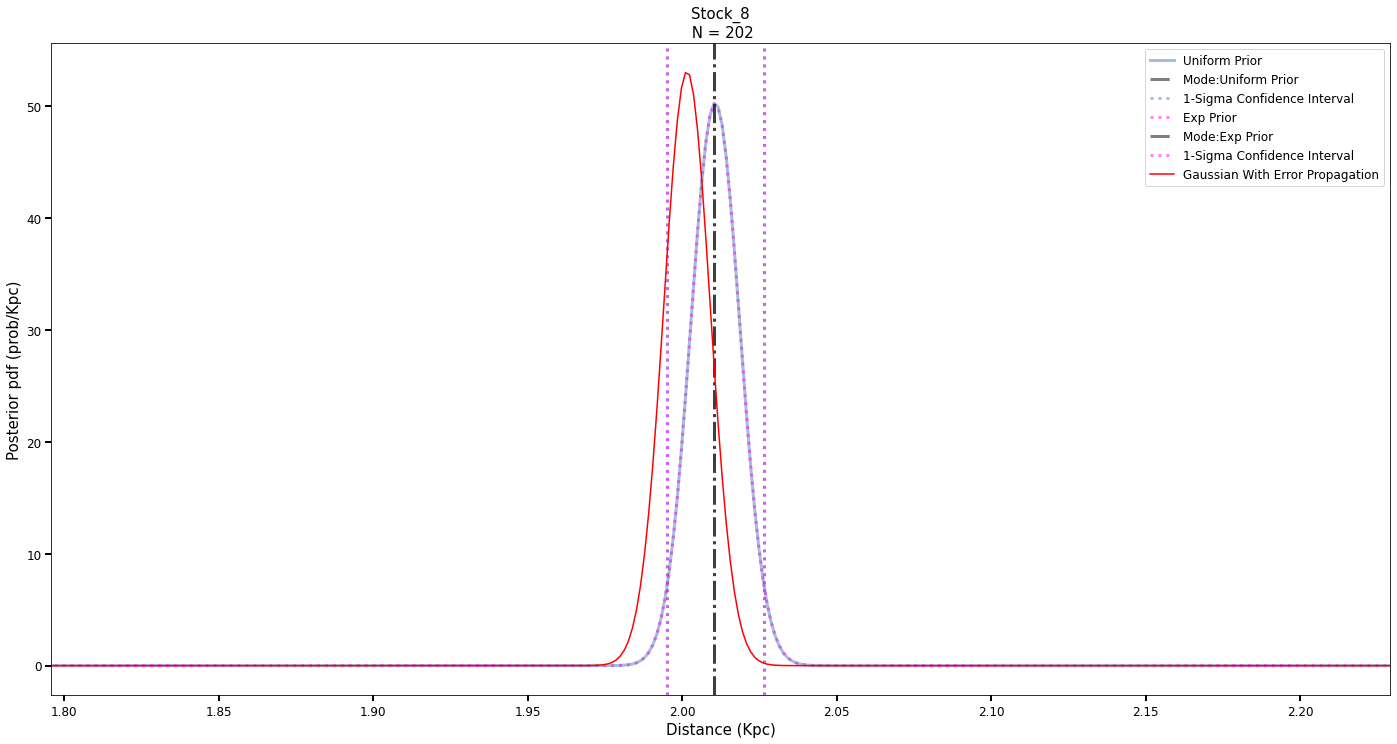

In [96]:
plt.figure(figsize=(24,12))

# Use the sample method with a seed to pick a random row and retrieve the 'Name' column
cluster_name = filtered_cluster_stats['Name'].sample(random_state=random_seed).iloc[0]

#cluster_name = 'Berkeley_39'
    
color='steelblue'
label='Uniform Prior'
linestyle='-'
prior_type = 'uniform'
result= bayesian_analysis_distance(cluster_df=stars, cluster_name=cluster_name, prior_type='uniform',
                                   plot=True, print_results=True, color=color, 
                                   label=label, linestyle=linestyle)

color='magenta'
label='Exp Prior'
linestyle=':'
prior_type ='exp'
result= bayesian_analysis_distance(cluster_df=stars, cluster_name=cluster_name, prior_type='exp',
                                   plot=True, print_results=True, color=color, 
                                   label=label, linestyle=linestyle)

#############################################################################
# Third Guassian plot

cluster_df = stars
dist_arr, posterior_pdf, max_likelihood_position, int95 = result
plx = cluster_df[cluster_df['Name'] == cluster_name]['Plx'].values
e_plx = cluster_df[cluster_df['Name'] == cluster_name]['e_Plx'].values
my_stars_plx = plx + gaia_corr # Adding correction factor
standard_std = np.std(my_stars_plx) / np.sqrt(len(my_stars_plx))


# Error propagation
mean_plx = np.mean(my_stars_plx)
mean_plx_ufloat = ufloat(mean_plx, standard_std)
distance = 1/ mean_plx_ufloat
sigma_distance = float(distance.std_dev)
mean_distance = float(distance.nominal_value)

# Plot
norm_values = norm.pdf(dist_arr, loc=mean_distance, scale=sigma_distance)

plt.plot(dist_arr, norm_values , color='red', label='Gaussian With Error Propagation')

plt.xlim (0.9 * int95[0], 1.1*int95[1])
plt.legend(fontsize=12)



Uniform Prior
Posterior pdf Integral value: 1.0
Maximum Likelihood Position: 2.0049230762629695  Kpc
1-Sigma Confidence Interval: [1.93792754 2.07957581]  Kpc


Exp Prior
Posterior pdf Integral value: 1.0
Maximum Likelihood Position: 2.0049230762629695  Kpc
1-Sigma Confidence Interval: [1.937944   2.07954462]  Kpc




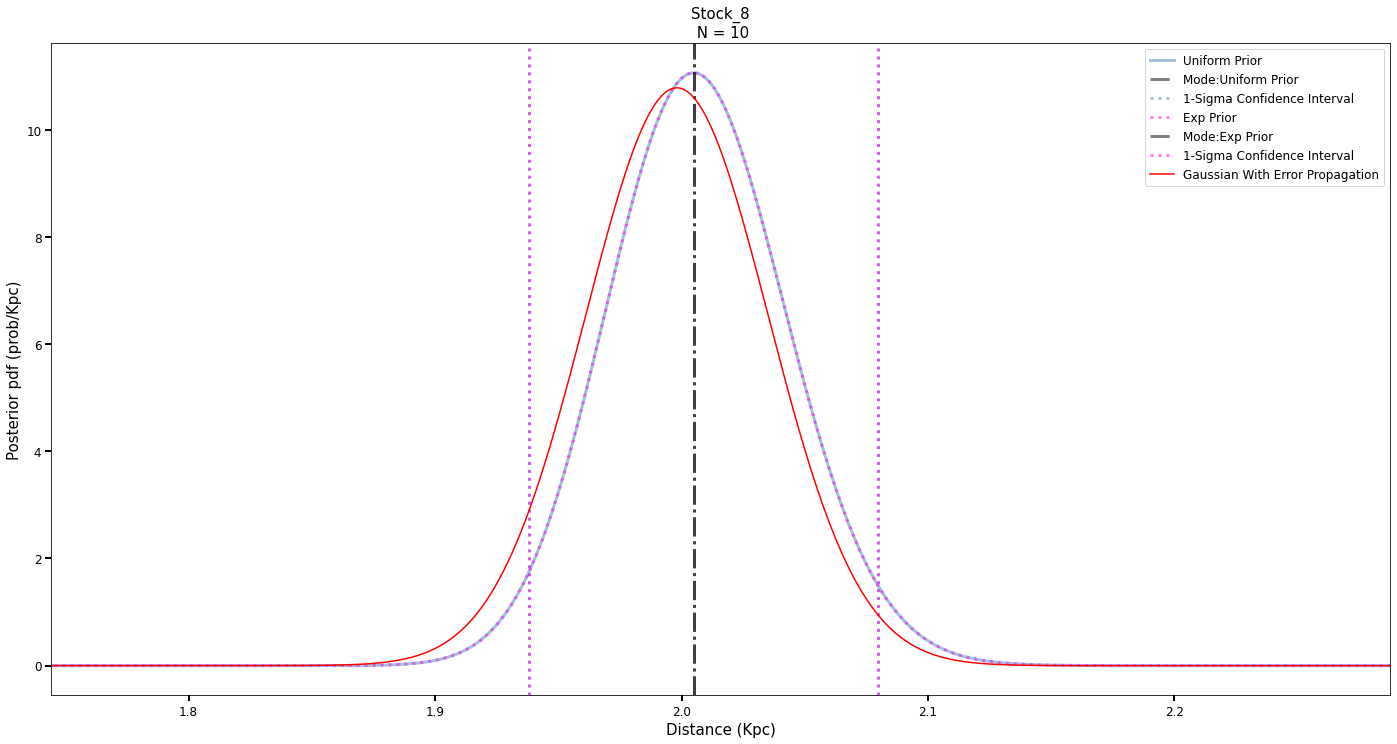

In [97]:
plt.figure(figsize=(24,12))


# Sample only 10 stars from the selected cluster
cluster_df_sample = stars[stars['Name'] == cluster_name].sample(n=10, random_state=random_seed)

    
color='steelblue'
label='Uniform Prior'
linestyle='-'
prior_type = 'uniform'
result= bayesian_analysis_distance(cluster_df=cluster_df_sample, cluster_name=cluster_name, prior_type='uniform',
                                   plot=True, print_results=True, color=color, 
                                   label=label, linestyle=linestyle)

color='magenta'
label='Exp Prior'
linestyle=':'
prior_type ='exp'
result= bayesian_analysis_distance(cluster_df=cluster_df_sample, cluster_name=cluster_name, prior_type='exp',
                                   plot=True, print_results=True, color=color, 
                                   label=label, linestyle=linestyle)

#############################################################################
# Third Guassian plot

cluster_df = cluster_df_sample
dist_arr, posterior_pdf, max_likelihood_position, int95 = result
plx = cluster_df[cluster_df['Name'] == cluster_name]['Plx'].values
e_plx = cluster_df[cluster_df['Name'] == cluster_name]['e_Plx'].values
my_stars_plx = plx + gaia_corr # Adding correction factor
standard_std = np.std(my_stars_plx) / np.sqrt(len(my_stars_plx))


# Error propagation
mean_plx = np.mean(my_stars_plx)
mean_plx_ufloat = ufloat(mean_plx, standard_std)
distance = 1/ mean_plx_ufloat
sigma_distance = float(distance.std_dev)
mean_distance = float(distance.nominal_value)

# Plot
norm_values = norm.pdf(dist_arr, loc=mean_distance, scale=sigma_distance)

plt.plot(dist_arr, norm_values , color='red', label='Gaussian With Error Propagation')

plt.xlim (0.9 * int95[0], 1.1*int95[1])
plt.legend(fontsize=12)



### Part 3 Comment

* The Uniform prior and exponetial prior provide equal results for several digits. This means that a uniform prior is a good guess and can even be used when more advanced priors are also known. 

* The posterior is a Guassian 
* The Bayesian approach provides different results compared to trying to make a Gaussian with error propagation. This is perhaps because the later method is biased as it gives equal weight to every sample? Perhaps a weighted mean and a weighted std(?) would better correspond to the Bayesian approach. 
* when using fewer samples, the Bayesian and Gaussian answers are further apart, and all distrubutions are wider, but peaked around the same values. This is the expected. 

### Conclusion 
* uniform priors rock!
* having more data points makes the confidence intervals more precise (narrow), maybe more accurate (close to true value)
* Bayesian approach is superior to making a normal distrubution with equal weighted mean and error propagation for calculated values


# Part 4:

Now repeat the Bayesian distance calculation for all clusters used in the correlation sample in Task 2,
using only the more realistic, constant density exponentially decreasing prior. You should obtain the
distance estimate for each cluster from the maximum posterior probability of �. Then, use your
distances to correct these 4 observed quantities to the values they would have at a fixed distance of 1
kpc: �& , �pos , �̅, �-. For these four corrected quantities, show the scatter-matrix plot and perform
Pearson and Spearman correlation tests. Comment on your results and how they differ compared to
what you obtained in Task 1 and 2 for the same quantities.


* labels = ['mean_parallax', 'std_parallax', 'mean_proper_motion', 'cluster_size', 'std_proper_motion']

- std_parallax
- cluster_size
- proper_motion
- std_proper_motion

### Idea:
* use function from 3 to compute the Bayesian based distanace paramter over our subset of clusters
* 'correction factor' to put clusters at 1kpc is simply the distance in Kpc and we use that to correct the cluster stastics 
* we use the same functions as we did earlier to make a corner plot and calculate correlations

### Assumptions:
* Same as for 2 and 3 (minus the uniform prior!)

### Hypothesis:
* Correlations will go away or be smaller, since we are correcting for the distance - the only variations left should be intrinsic


In [77]:

# Run Bayesian distance calculation on all unique cluster names
unique_names = filtered_cluster_stats['Name']
distance_results_df = pd.DataFrame() # Initalize results df 
filtered_cluster_stats_corr = pd.DataFrame() # Initalize df for the corrections
for name in unique_names:
    dist_arr, posterior_pdf, max_likelihood_position, int95 = bayesian_analysis_distance(cluster_df=stars, cluster_name=name, prior_type='exp',
                                    plot=False, print_results=False, color=color, 
                                    label=label, linestyle=linestyle)

    # Create a temp df for the current iteration
    temp_df = pd.DataFrame({
            'Name': [name],
            'Max_Likelihood_Position_kpc': [max_likelihood_position],
            'lower_1sigma_kpc': int95[0], 
            'higher_1sigma_kpc': int95[1],
        })

    # Concatenate the temp df to the results_df
    distance_results_df = pd.concat([distance_results_df, temp_df], ignore_index=True)

    # Make corrections and save to output df
    correction_factor = max_likelihood_position

    # Temp corr df
    temp_df = pd.DataFrame({
        'Name': name,
        'mean_parallax':  filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['mean_parallax'] * correction_factor,
        'std_parallax': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['std_parallax']* correction_factor,
        'mean_proper_motion': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['mean_proper_motion'] * correction_factor,
        'cluster_size': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['cluster_size'] * correction_factor,
        'std_proper_motion': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['std_proper_motion'] * correction_factor,
    })

    # Concatenate the temp df to the stars_corr_df
    filtered_cluster_stats_corr = pd.concat([filtered_cluster_stats_corr, temp_df], ignore_index=True)

filtered_cluster_stats_corr




/tmp/ipykernel_22062/2889613638.py:66: RuntimeWarning: invalid value encountered in divide
  posterior_pdf = likel_ln  / likel_ln_int
/tmp/ipykernel_22062/2889613638.py:60: RuntimeWarning: overflow encountered in exp
  likel_ln = np.exp(loglikel_ln ) # convert back from log space
/home/afinemax/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:416: RuntimeWarning: overflow encountered in multiply
  y[slice1] * (hsum * hsum / hprod) +
/tmp/ipykernel_22062/2889613638.py:58: RuntimeWarning: divide by zero encountered in log
  loglikel_ln = np.sum(sps.norm.logpdf(x=x, scale=scale, loc=loc,), axis=0)+ np.log(prior)
/tmp/ipykernel_22062/2889613638.py:54: RuntimeWarning: overflow encountered in exp
  prior = (dist_arr)**2 * np.exp(-dist_arr)
/tmp/ipykernel_22062/2889613638.py:54: RuntimeWarning: overflow encountered in multiply
  prior = (dist_arr)**2 * np.exp(-dist_arr)
/home/afinemax/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:415: RuntimeWarning:

,Name,mean_parallax,std_parallax,mean_proper_motion,cluster_size,std_proper_motion
0,BH_131,0.804957,0.296090,41.881394,1.420300,0.989267
1,BH_140,0.882039,0.201671,69.085773,0.590933,0.601236
2,BH_66,0.809288,0.295620,35.967888,1.188978,1.508880
3,Berkeley_36,0.885046,0.268218,8.012931,0.257512,0.404692
4,Berkeley_39,0.903598,0.152425,9.440538,0.181686,0.273281
...,...,...,...,...,...,...
193,UBC_461,0.895641,0.095255,12.280952,1.256789,0.329331
194,UBC_517,0.928688,0.051926,13.015642,1.641106,0.291877
195,UBC_600,0.824658,0.190544,5.740606,3.476066,0.646966
196,UFMG_2,0.939639,0.066731,13.404857,0.182385,0.255159


/tmp/ipykernel_22062/2416371608.py:36: RuntimeWarning: invalid value encountered in log10
  axes[i, j].hist(np.log10(plotting_df[parameters[i]].values), bins=20, color=color, alpha=0.7)
/tmp/ipykernel_22062/2416371608.py:38: RuntimeWarning: invalid value encountered in log10
  axes[i, j].scatter(np.log10(plotting_df[parameters[j]].values), np.log10(plotting_df[parameters[i]].values), color=color, alpha=0.3, linewidths=0.5)


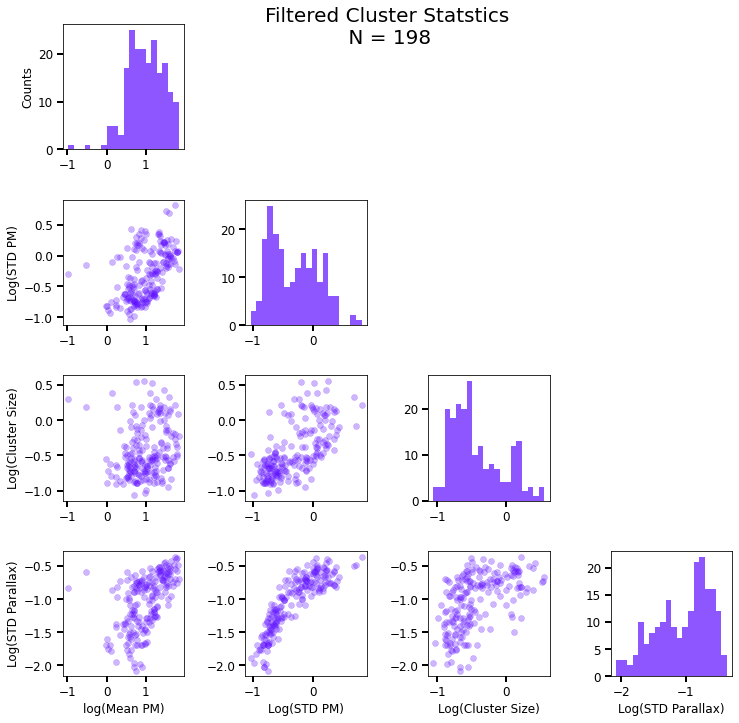

In [78]:
plotting_df = filtered_cluster_stats_corr
labels = ['log(Mean PM)', 'Log(STD PM)', 'Log(Cluster Size)', 'Log(STD Parallax)',]
parameters = ['mean_proper_motion', 'std_proper_motion', 'cluster_size', 'std_parallax',]
corner_plot(labels, plotting_df, parameters)



In [79]:
# correlations
parameters = ['mean_proper_motion', 'std_proper_motion', 'cluster_size', 'std_parallax',]
correlations = pearson_and_spearman_corr(dataframe=filtered_cluster_stats_corr, parameters=parameters, log=False)
correlations

/tmp/ipykernel_22062/1600713121.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([


,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_proper_motion vs std_proper_motion,0.998219,6.196919e-242,0.543851,1.231728e-16
1,mean_proper_motion vs cluster_size,0.997620,1.286047e-229,0.272919,1.002010e-04
2,mean_proper_motion vs std_parallax,0.998545,1.530496e-250,0.621674,1.464188e-22
3,std_proper_motion vs cluster_size,0.999565,6.277217e-302,0.675898,8.827582e-28
4,std_proper_motion vs std_parallax,0.999857,0.000000e+00,0.881928,6.177180e-66
5,cluster_size vs std_parallax,0.999558,2.895029e-301,0.590922,4.992684e-20


In [80]:
# correlations
parameters = ['mean_proper_motion', 'std_proper_motion', 'cluster_size', 'std_parallax',]
log_correlations = pearson_and_spearman_corr(dataframe=filtered_cluster_stats_corr, parameters=parameters, log=True)
log_correlations

/tmp/ipykernel_22062/1600713121.py:36: RuntimeWarning: invalid value encountered in log10
  log_data1 = np.log10(np.ma.masked_invalid(dataframe[label1]))
/tmp/ipykernel_22062/1600713121.py:37: RuntimeWarning: invalid value encountered in log10
  log_data2 = np.log10(np.ma.masked_invalid(dataframe[label2]))
/tmp/ipykernel_22062/1600713121.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([


,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_proper_motion vs std_proper_motion,0.485548,4.157839e-13,0.532505,6.777911e-16
1,mean_proper_motion vs cluster_size,0.166797,1.884107e-02,0.259961,2.167879e-04
2,mean_proper_motion vs std_parallax,0.511614,1.331563e-14,0.611407,1.101348e-21
3,std_proper_motion vs cluster_size,0.663796,1.604433e-26,0.675898,8.827582e-28
4,std_proper_motion vs std_parallax,0.864726,1.574170e-60,0.881928,6.177180e-66
5,cluster_size vs std_parallax,0.581021,2.868000e-19,0.590922,4.992684e-20


### Comments on 4

### Corner Plot:
* Data appears to be log normally distrubuted, but possible with mulitple populations? there appear to be log normal distrubutions with different means
* strong correlations between STD PM, STD paralax, and mean PM which makes sense as its likely a instrumental limit on measuring as the cause of the correlation
* cluster size and parallax have a week but visible correlation. Very week compared to the first corner plot, indicating a large factor of the correlation was distance. Perhaps the correlation now has to deal with how different sized star clusters are distrubuted in the galaxy? Bigger (or smaller) ones being slightly biased to be closer to the galacitic center might explain this. 
* there is a correlation between STD PM and cluster size, likely a smaller cluster has a more well defined proper motion and vice versa?


### Correlations
* everything is strongly corrected (p value much less then 1e-7, or ~ 5 sigma) except mean_proper_motion vs cluster_size
* This is very interesting! correcting for distance has appeared to increase! correlations, I thought it would have made the varius parameters uncorrelated or at least less correlated.  This seems to have only happend to proper motion and cluster size which appear now as uncorrelated


### Conclusion: 
* parameters for star clusters are strongly correlated when accounting for there distance (at least how *I* accounted for their distance)
    - STD PM, STD paralax, and mean PM are all highly correlated. I propose that it is due to instrumental limits in measurements?
* proper motion and cluster size are not correlated (null hypothesis not rejected at the ~5 sigma level) when accounting for the distance. 
    - This is the opposite conclusion from 2! indicating star clusters size and their PM only appear to be correlated because distance is involved in both PM and their apparent size
